In [1]:
import pandas as pd
import numpy as np
import glob, os, librosa, soundfile 

import librosa.display

import matplotlib.pyplot as plt
from IPython.display import Audio

In [2]:
params = {
    'train_strong': './metadata/strong/audioset_train_strong.tsv',
    'eval_strong': './metadata/strong/audioset_eval_strong.tsv',
    'label_tsv': './metadata/strong/mid_to_display_name.tsv'
}

In [3]:
label_data = pd.read_csv(params['label_tsv'], delimiter='\t', header=None)
label_data.rename({0: 'label', 1: 'class'}, axis=1, inplace=True)
label_data['class'] = label_data['class'].apply(lambda x: x.replace(' ', '-'))
print(label_data.shape)
label_data.head(1)

(456, 2)


,label,class
0,/g/11b630rrvh,Kettle-whistle


In [4]:
train_data = pd.read_csv(params['train_strong'], delimiter='\t')
train_data = pd.merge(train_data, label_data, on='label')
train_data['segment_id'] = train_data['segment_id'].apply(lambda x: '_'.join(x.split('_')[:-1]))
print(train_data.shape)
train_data.head(3)

(934821, 5)


,segment_id,start_time_seconds,end_time_seconds,label,class
0,b0RFKhbpFJA,0.0,10.000,/m/03m9d0z,Wind
1,ZvAdd4Jb1xA,0.0,10.000,/m/03m9d0z,Wind
2,sWdJR9dInhw,0.0,9.803,/m/03m9d0z,Wind


In [5]:
eval_data = pd.read_csv(params['eval_strong'], delimiter='\t')
eval_data = pd.merge(eval_data, label_data, on='label')
eval_data['segment_id'] = eval_data['segment_id'].apply(lambda x: '_'.join(x.split('_')[:-1]))
print(eval_data.shape)
eval_data.head(3)

(139538, 5)


,segment_id,start_time_seconds,end_time_seconds,label,class
0,s9d-2nhuJCQ,0.000,10.000,/m/04rlf,Music
1,YxlGt805lTA,0.000,9.378,/m/04rlf,Music
2,-ByoSbgzr4M,0.069,10.000,/m/04rlf,Music


In [6]:
RESAMPLE_RATE = 32000
SPLIT_TIME_THR = 3.0

In [7]:
def split_segment_data(process_dir, metadata, save_dir):    
    wav_files = glob.glob(f'{process_dir}/*.wav')
    save_dir = os.path.join(save_dir, 'data')
    # print(len(wav_files))

    segment_ids = metadata['segment_id'].unique()
    for wav_file in wav_files:
        wav_id = os.path.splitext(os.path.basename(wav_file))[0][1:]
        if wav_id not in segment_ids: continue
        print(wav_file)
        wav_data, sr = librosa.load(wav_file, mono=False)
        wav_data = librosa.resample(wav_data, orig_sr=sr, target_sr=RESAMPLE_RATE)
        # plt.figure(figsize=(12, 4))
        # librosa.display.waveshow(wav_data, sr=sr)
        # plt.show()  

        wav_meta = metadata[metadata['segment_id'] == wav_id]
        new_wav_id = 0
        for _, meta_item in wav_meta.iterrows():
            start_time_seconds = meta_item['start_time_seconds']
            end_time_seconds = meta_item['end_time_seconds']
            seg_class = meta_item['class']
            if end_time_seconds - start_time_seconds > SPLIT_TIME_THR:
                continue
            start_sample_point = int(start_time_seconds * RESAMPLE_RATE)
            end_sample_point = int(end_time_seconds * RESAMPLE_RATE)
            sub_wav = wav_data[start_sample_point:end_sample_point]
            save_wav_file = os.path.join(save_dir, seg_class, f'{wav_id}_{new_wav_id}.wav')
            os.makedirs(os.path.dirname(save_wav_file), exist_ok=True)
            soundfile.write(save_wav_file, sub_wav, RESAMPLE_RATE)
        # print(wav_meta)
        break

In [8]:
train_wav_dirs = glob.glob('./data/audioset/unbalanced_train_segments/*')

for train_wav_dir in train_wav_dirs:
    split_segment_data(train_wav_dir, train_data, '/media/ubuntu/HD/Data/Audioset-Seg')
    break

./data/audioset/unbalanced_train_segments/unbalanced_train_segments_part32/Yjj-39Vkt8jo.wav


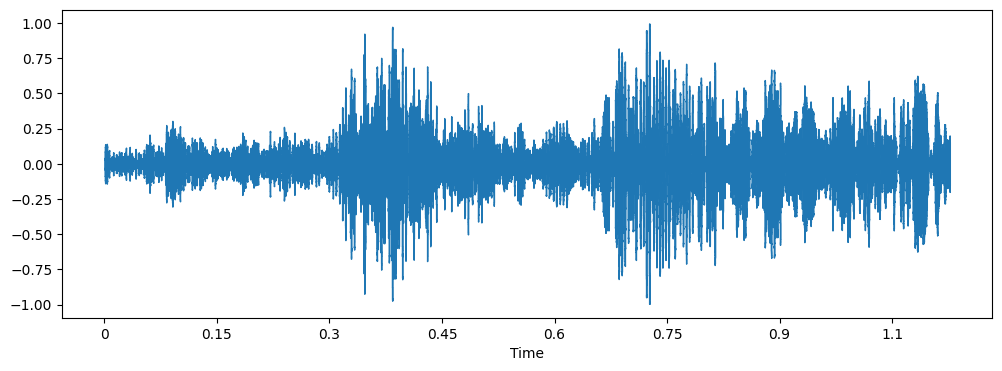

In [9]:
wav_file = '/media/ubuntu/HD/Data/Audioset-Seg/data/Human-voice/jj-39Vkt8jo_0.wav'
wav_data, sr = librosa.load(wav_file, mono=False)
plt.figure(figsize=(12, 4))
librosa.display.waveshow(wav_data, sr=sr)
plt.show()  